## Usual imports

To use `dtreeviz` and `svglib` you probably need to install it first with
```
pip install dtreeviz

```
from commandline. `svglib` is only used to create a pdf file from tree visualization.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from dtreeviz.trees import dtreeviz
# import svglib

In [3]:
import sklearn.tree as sktree
import sklearn.ensemble as skensemble
import sklearn.datasets as datasets


from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, make_scorer, mean_absolute_error, accuracy_score
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import itertools

In [4]:
def ISLR2data(name):
    import io
    import zipfile
    import urllib
    url = ("https://www.statlearning.com/s/"
           "ALL-CSV-FILES-2nd-Edition-corrected.zip")
    zipdata = urllib.request.urlopen(url).read()
    with zipfile.ZipFile(io.BytesIO(zipdata)) as zf:
        for zi in zf.filelist:
            if name in zi.filename:
                with zf.open(zi) as f:
                    df = pd.read_csv(f, index_col=0)
                break
    return df

def ISLRdata(name):
    import statsmodels.datasets as smd
    data = smd.get_rdataset(name, 'ISLR')
    for k in ['__doc__', 'title', 'package']:
        setattr(data.data, k, getattr(data, k, ''))
    return data.data

def print_report(model, X, y):
    y_pred = model.predict(X)
    cm = pd.DataFrame(confusion_matrix(y_pred=y_pred, y_true=y, labels=model.classes_), 
                      columns=model.classes_, index=model.classes_)
    cm.index.name = 'True'
    cm.columns.name = 'Predicted'
    return cm

def viz2pdf(viz, fn):
    from reportlab.graphics import renderPDF
    from svglib.svglib import svg2rlg
    import io

    renderPDF.drawToFile(
        svg2rlg(io.BytesIO(viz.svg().encode())), 
        fn, 
        showBoundary=False
    )
    

In [5]:
#print(ISLRdata('NCI60').__doc__)

In [6]:
def data_splits(X, y, **kwargs):
    X_train, X_test, y_train, y_test = train_test_split(X, y, **kwargs)
    return {'train': (X_train, y_train), 'test': (X_test, y_test)}


In [7]:
X,y = datasets.make_blobs(centers=2, cluster_std=7, shuffle=True, random_state=1)
X.shape, y.shape

((100, 2), (100,))

<AxesSubplot:>

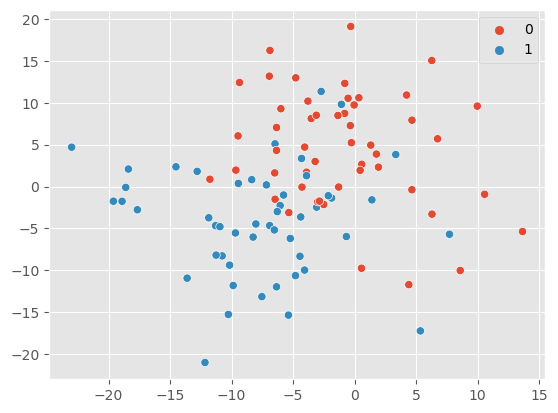

In [8]:
sns.scatterplot(x=X[:,0], y=X[:,1], hue=y)

In [9]:
dt = sktree.DecisionTreeClassifier(max_leaf_nodes=6, random_state=1).fit(X, y)

In [10]:
dtreeviz?

Signature:
dtreeviz(
    tree_model,
    x_data: (<class 'pandas.core.frame.DataFrame'>, <class 'numpy.ndarray'>) = None,
    y_data: (<class 'pandas.core.frame.DataFrame'>, <class 'numpy.ndarray'>) = None,
    feature_names: List[str] = None,
    target_name: str = None,
    class_names: (typing.Mapping[numbers.Number, str], typing.List[str]) = None,
    tree_index: int = None,
    precision: int = 2,
    orientation: ('TD', 'LR') = 'TD',
    instance_orientation: ('TD', 'LR') = 'LR',
    show_root_edge_labels: bool = True,
    show_node_labels: bool = False,
    show_just_path: bool = False,
    fancy: bool = True,
    histtype: ('bar', 'barstacked', 'strip') = 'barstacked',
    highlight_path: List[int] = [],
    X: numpy.ndarray = None,
    max_X_features_LR: int = 10,
    max_X_features_TD: int = 20,
    depth_range_to_display: tuple = None,
    label_fontsize: int = 12,
    ticks_fontsize: int = 8,
    fontname: str = 'Arial',
    title: str = None,
    title_fontsize: int = 14,


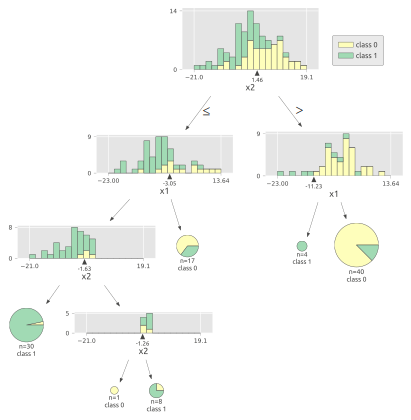

In [11]:
viz = dtreeviz(
    dt, 
    X, 
    y, 
    feature_names=['x1','x2'], 
    scale=1,
    fontname='ubuntu'
    )
viz

## Tree representation in `sklearn.tree` 

In [12]:
def tree_asdf(tree, columns=None):
    if columns is None:
        columns ="feature threshold value children_left children_right".split()
    return pd.DataFrame({k: list(getattr(tree, k).squeeze()) for k in columns})


In [13]:
dt.tree_?

Type:        Tree
String form: <sklearn.tree._tree.Tree object at 0x7f07c2aba340>
File:        ~/.config/jupyterlab-desktop/jlab_server/lib/python3.8/site-packages/sklearn/tree/_tree.cpython-38-x86_64-linux-gnu.so
Docstring:  
Array-based representation of a binary decision tree.

The binary tree is represented as a number of parallel arrays. The i-th
element of each array holds information about the node `i`. Node 0 is the
tree's root. You can find a detailed description of all arrays in
`_tree.pxd`. NOTE: Some of the arrays only apply to either leaves or split
nodes, resp. In this case the values of nodes of the other type are
arbitrary!

Attributes
----------
node_count : int
    The number of nodes (internal nodes + leaves) in the tree.

capacity : int
    The current capacity (i.e., size) of the arrays, which is at least as
    great as `node_count`.

max_depth : int
    The depth of the tree, i.e. the maximum depth of its leaves.

children_left : array of int, shape [node_count]


In [14]:
tree_asdf(dt.tree_)

,feature,threshold,value,children_left,children_right
0,1,1.464374,"[50.0, 50.0]",1,2
1,0,-3.047887,"[15.0, 41.0]",3,4
2,0,-11.230524,"[35.0, 9.0]",5,6
3,1,-1.628591,"[4.0, 35.0]",7,8
4,-2,-2.000000,"[11.0, 6.0]",-1,-1
5,-2,-2.000000,"[0.0, 4.0]",-1,-1
6,-2,-2.000000,"[35.0, 5.0]",-1,-1
7,-2,-2.000000,"[1.0, 29.0]",-1,-1
8,1,-1.260661,"[3.0, 6.0]",9,10
9,-2,-2.000000,"[1.0, 0.0]",-1,-1


In [15]:
def cut_lines(dt, X, y=None):
    X = np.asarray(X).astype(np.float64)
    tree_df = tree_asdf(dt.tree_)
    xmin, xmax = X.min(axis=0), X.max(axis=0)
    xcenter = (xmin+xmax)/2
    xmin, xmax = 1.1*(xmin-xcenter)+xcenter, 1.1*(xmax-xcenter)+xcenter
    bbox = np.stack([xmin, xmax], axis=1)
    # print(bbox)
    bboxes = [bbox for i in range(len(tree_df))]
    clines = []
    idx = [0]
    while idx:
        i = idx[0]
        idx = idx[1:]
        (c, f, l, r) = tree_df[['threshold', 'feature', 'children_left', 'children_right']].iloc(0)[i]
        f, l, r = int(f), int(l), int(r) 
        if (l>=0):
            idx.append(l)
            bboxes[l] = bboxes[i].copy()
            bboxes[l][f, 1] = c
            #print(bboxes[i],bboxes[l],sep='\n',end='\n\n')
        if (r>=0):
            idx.append(r)
            bboxes[r] = bboxes[i].copy()
            bboxes[r][f, 0] = c
        if f>=0:
            cline = bboxes[i].copy()
            cline[f] = c
            clines.append(cline)
    return clines


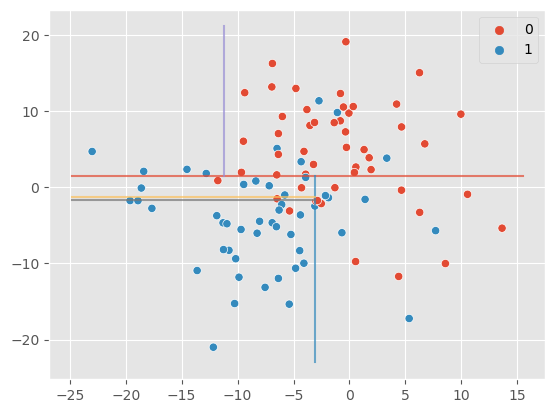

In [16]:
sns.scatterplot(x=X[:,0],y=X[:,1], hue=y)
for cline in cut_lines(dt, X):
    plt.plot( *cline, '-', alpha=0.7)

## Hitters data

In [17]:
hitter = ISLRdata('Hitters')

In [18]:
print(hitter.__doc__)

.. container::

   ======= ===============
   Hitters R Documentation
   ======= ===============

   .. rubric:: Baseball Data
      :name: baseball-data

   .. rubric:: Description
      :name: description

   Major League Baseball Data from the 1986 and 1987 seasons.

   .. rubric:: Usage
      :name: usage

   ::

      Hitters

   .. rubric:: Format
      :name: format

   A data frame with 322 observations of major league players on the
   following 20 variables.

   ``AtBat``
      Number of times at bat in 1986

   ``Hits``
      Number of hits in 1986

   ``HmRun``
      Number of home runs in 1986

   ``Runs``
      Number of runs in 1986

   ``RBI``
      Number of runs batted in in 1986

   ``Walks``
      Number of walks in 1986

   ``Years``
      Number of years in the major leagues

   ``CAtBat``
      Number of times at bat during his career

   ``CHits``
      Number of hits during his career

   ``CHmRun``
      Number of home runs during his career

   ``CRuns``
    

In [19]:
hitter.info()

<class 'pandas.core.frame.DataFrame'>
Index: 322 entries, -Andy Allanson to -Willie Wilson
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AtBat      322 non-null    int64  
 1   Hits       322 non-null    int64  
 2   HmRun      322 non-null    int64  
 3   Runs       322 non-null    int64  
 4   RBI        322 non-null    int64  
 5   Walks      322 non-null    int64  
 6   Years      322 non-null    int64  
 7   CAtBat     322 non-null    int64  
 8   CHits      322 non-null    int64  
 9   CHmRun     322 non-null    int64  
 10  CRuns      322 non-null    int64  
 11  CRBI       322 non-null    int64  
 12  CWalks     322 non-null    int64  
 13  League     322 non-null    object 
 14  Division   322 non-null    object 
 15  PutOuts    322 non-null    int64  
 16  Assists    322 non-null    int64  
 17  Errors     322 non-null    int64  
 18  Salary     263 non-null    float64
 19  NewLeague  322 non-null    obje

In [20]:
hitter.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
-Andy Allanson,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
-Alan Ashby,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
-Alvin Davis,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
-Andre Dawson,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
-Andres Galarraga,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


## Data cleaning.

Records with missing values are dropped. Categorical variables are transformed into numbers.

In [22]:
hitter.dropna(inplace=True)

for x in ['League', 'Division', 'NewLeague']:
    hitter[x], levels = pd.factorize(hitter[x])
    
hitter.League.values, hitter.League.attrs, levels

(array([0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1,
        0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0,
        1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1,
        1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1,
        0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1,
        0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1,
        1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0,
        1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0,
        0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1,
        1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1,
        1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0,
        1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1]),
 {},
 Int64Index([0, 1], dtype='int64'))

## Regression tree for log salary

[Decision trees for regression in `sklearn`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor)

In [24]:
X, y = hitter[['Years', 'Hits']], np.log(hitter.Salary)
 
ds = data_splits(X, y, test_size=0.25, shuffle=True, random_state=42)

hitter_tree = sktree.DecisionTreeRegressor(ccp_alpha=0.1, random_state=42).fit(*ds['train'])
print(hitter_tree.tree_.n_leaves)

3


/home/prokaj/.config/jupyterlab-desktop/jlab_server/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


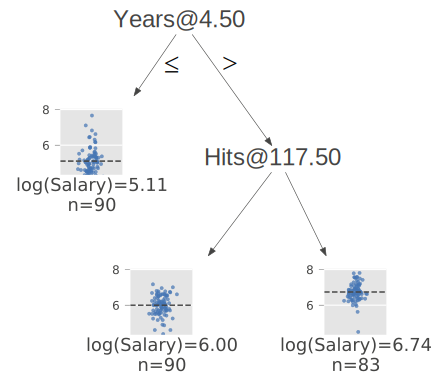

In [25]:
viz = dtreeviz(
    hitter_tree, 
    X, y,
    #hitter[['Years', 'Hits']], 
    #np.log(hitter.Salary),
    feature_names=['Years','Hits'], 
    target_name='log(Salary)', 
    # orientation='LR',
    fancy=False,
    # show_root_edge_labels=False,
    scale=2, 
    label_fontsize=12
    )
viz

In [26]:
X.columns

Index(['Years', 'Hits'], dtype='object')

In [27]:
MSE_score = make_scorer(mean_squared_error)

print(
    f'train error {MSE_score(hitter_tree, *ds["train"]).round(2)}, '
    f'test error {MSE_score(hitter_tree, *ds["test"]).round(2)}'
    )

train error 0.32, test error 0.44


In [28]:
hitter_tree.tree_.n_node_samples

array([197,  67, 130,  68,  62], dtype=int64)

In [29]:
tree_asdf(hitter_tree.tree_, "feature threshold value impurity n_node_samples children_left children_right".split())


,feature,threshold,value,impurity,n_node_samples,children_left,children_right
0,0,4.5,5.937406,0.813625,197,1,2
1,-2,-2.0,5.068106,0.433041,67,-1,-1
2,1,117.5,6.385430,0.419581,130,3,4
3,-2,-2.0,6.005603,0.343983,68,-1,-1
4,-2,-2.0,6.802015,0.170721,62,-1,-1


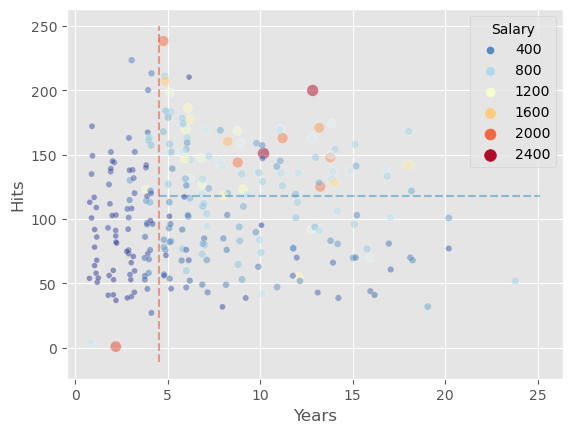

In [30]:
h = hitter['Years Hits Salary'.split()].copy()

h['Years'] = h.Years + np.random.uniform(-0.25, 0.25, size=h.Years.shape)
h['Hits']  = h.Hits  + np.random.uniform(-0.25, 0.25, size=h.Hits.shape)

plt.style.use('ggplot')

sns.scatterplot(x='Years', y='Hits', hue='Salary',
                data=h, palette='RdYlBu_r', 
                alpha=0.5, size='Salary')

for line in cut_lines(hitter_tree, X):
    plt.plot(*line,'--',alpha=0.5)

In [31]:
ccp_alphas = hitter_tree.cost_complexity_pruning_path(*ds['train'])['ccp_alphas']

n_leaves = pd.DataFrame(
    [
        {
            'alpha': a1,
            'n_leaves': sktree.DecisionTreeRegressor(ccp_alpha=0.5*(a1+a2)).fit(*ds['train']).get_n_leaves() 
        }
        for a1, a2 in  zip(ccp_alphas, ccp_alphas[1:])
    ] + [
        {'alpha': ccp_alphas[-1], 'n_leaves': 1}
    ]
)
  

In [32]:
n_leaves[:20]

,alpha,n_leaves
0,0.000000e+00,191
1,7.213632e-17,190
2,1.171759e-08,189
3,3.554397e-07,188
4,1.190915e-06,187
5,1.226072e-06,186
6,2.132683e-06,185
7,2.237911e-06,183
8,2.403287e-06,182
9,3.889392e-06,181


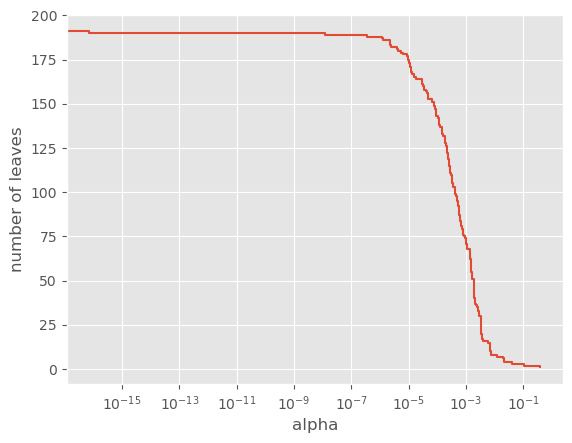

In [35]:
plt.plot('alpha', 'n_leaves', data=n_leaves, drawstyle='steps-post')
#plt.yscale('log')
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('number of leaves')
plt.show()

In [73]:
np.unique(n_leaves.n_leaves)

array([  1,   2,   3,   4,   6,   7,   8,  10,  15,  16,  17,  19,  20,
        24,  25,  28,  30,  32,  33,  34,  35,  36,  37,  40,  43,  50,
        51,  53,  54,  55,  61,  62,  64,  67,  68,  69,  70,  71,  72,
        74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  87,
        88,  92,  93,  94,  95,  97,  98,  99, 101, 102, 103, 105, 106,
       108, 110, 111, 112, 114, 115, 116, 117, 119, 120, 121, 122, 123,
       124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 135, 136, 137,
       138, 139, 140, 141, 142, 143, 146, 147, 148, 149, 151, 152, 153,
       154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166,
       167, 168, 169, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180,
       181, 182, 183, 185, 186, 187, 188, 189, 190, 191])

In [36]:
def ccp_curve(model, X, y, train_idx, val_idx):
    X, y = np.asarray(X), np.asarray(y)
    train = X[train_idx], y[train_idx]
    X_val, y_val = X[val_idx], y[val_idx]

    cpp_path = model.set_params(ccp_alpha=0).cost_complexity_pruning_path(*train)
    
    results = []

    for alpha in cpp_path['ccp_alphas']: 
        y_pred = model.set_params(ccp_alpha=alpha).fit(*train).predict(X_val)
        results.append(
            {
                'alpha': alpha, 
                'mse': mean_squared_error(y_true=y_val, y_pred=y_pred)
            }
        )
    return pd.DataFrame(results)

def ccp_curve2(model, alphas, X, y, train_idx, val_idx):

    X, y = np.asarray(X), np.asarray(y)
    train = X[train_idx], y[train_idx]
    X_val, y_val = X[val_idx], y[val_idx]
    results = []

    for alpha in alphas:
        y_pred = model.set_params(ccp_alpha=alpha).fit(*train).predict(X_val)
        results.append(
            {
                'alpha': alpha, 
                'mse': mean_squared_error(y_true=y_val, y_pred=y_pred)
            }
        )

    return pd.DataFrame(results)


In [90]:
sktree.DecisionTreeRegressor?

Init signature:
sktree.DecisionTreeRegressor(
    *,
    criterion='squared_error',
    splitter='best',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features=None,
    random_state=None,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    ccp_alpha=0.0,
)
Docstring:     
A decision tree regressor.

Read more in the :ref:`User Guide <tree>`.

Parameters
----------
criterion : {"squared_error", "friedman_mse", "absolute_error",             "poisson"}, default="squared_error"
    The function to measure the quality of a split. Supported criteria
    are "squared_error" for the mean squared error, which is equal to
    variance reduction as feature selection criterion and minimizes the L2
    loss using the mean of each terminal node, "friedman_mse", which uses
    mean squared error with Friedman's improvement score for potential
    splits, "absolute_error" for the mean absolute error, which minimizes
    the L1 l

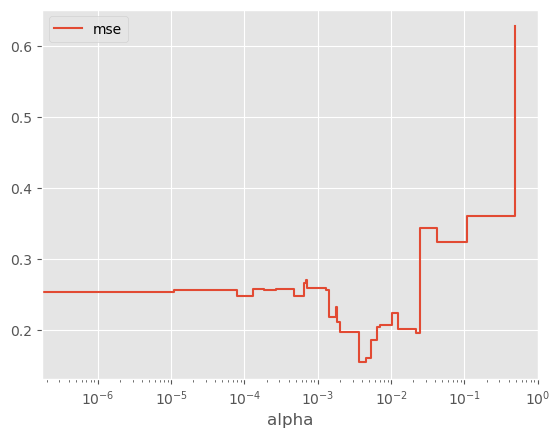

In [37]:
cv0 = ccp_curve(sktree.DecisionTreeRegressor(random_state=42), *ds['train'], slice(0, 100), slice(100, 110))

cv0.set_index('alpha').plot(drawstyle='steps-post')
plt.xscale('log')


In [38]:
X, y = hitter[['Years', 'Hits']] , np.log(hitter.Salary) 

np.random.seed(42)
ds = data_splits(X, y, test_size=0.25, shuffle=True)

kfold = KFold(
      n_splits=5, 
      shuffle=True, 
)

cv = [
      ccp_curve(
            sktree.DecisionTreeRegressor(), 
            *ds['train'], 
            *idx
      ) 
      for idx in kfold.split(*ds['train'])
]


In [39]:
def midpoints(x):
    return 0.5*(x[:-1]+x[1:])

In [40]:
alphas = np.concatenate([x.alpha for x in cv])
alphas.sort()
alphas = midpoints(alphas)
len(alphas)

585

In [41]:
from bisect import bisect

In [42]:
def mse_for_alpha(alpha, df):
    i = max(0, bisect(df.alpha, alpha))-1
    return df.mse[i]

In [46]:
a = 1e-17
cv[0].alpha, bisect(cv[0].alpha, a)-1


(0      0.000000e+00
 1      1.810300e-16
 2      1.470296e-08
 3      4.459976e-07
 4      8.996154e-07
            ...     
 110    1.934503e-02
 111    2.320576e-02
 112    4.495687e-02
 113    1.170154e-01
 114    3.667848e-01
 Name: alpha, Length: 115, dtype: float64,
 0)

In [167]:
bisect?

Docstring:
bisect_right(a, x[, lo[, hi]]) -> index

Return the index where to insert item x in list a, assuming a is sorted.

The return value i is such that all e in a[:i] have e <= x, and all e in
a[i:] have e > x.  So if x already appears in the list, i points just
beyond the rightmost x already there

Optional args lo (default 0) and hi (default len(a)) bound the
slice of a to be searched.
Type:      builtin_function_or_method


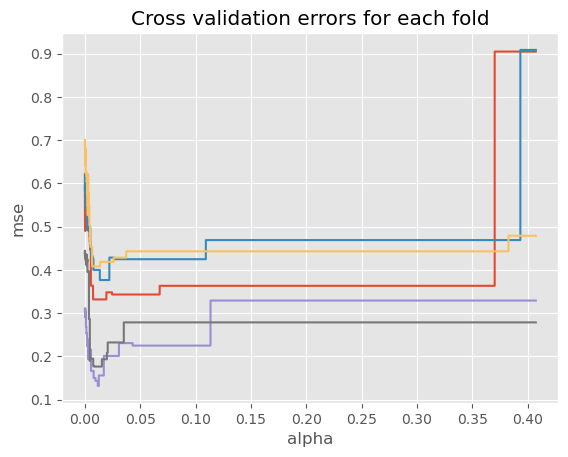

In [50]:

mse_cv = np.array([[mse_for_alpha(a, x) for a in alphas] for x in cv])

plt.plot(alphas, mse_cv.T, drawstyle='steps-post')
plt.xlabel('alpha')
plt.ylabel('mse')
plt.title('Cross validation errors for each fold')

plt.show()


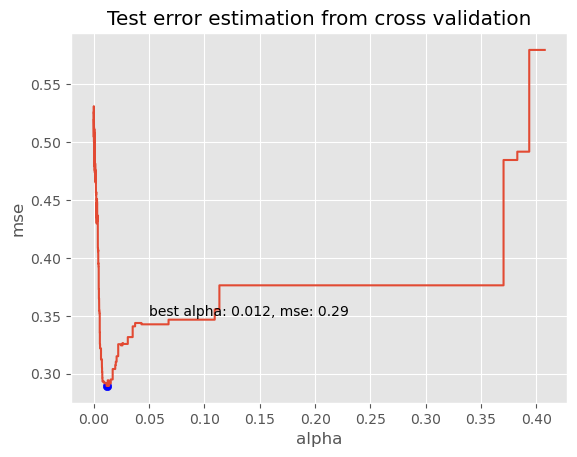

In [51]:


mse_alpha = mse_cv.mean(axis=0)
k = np.argmin(mse_alpha)
best_alpha= alphas[k]
best_mse = mse_alpha[k]

plt.plot(alphas, mse_alpha, drawstyle='steps-post')
plt.scatter(x=best_alpha, y=best_mse, color='blue')

plt.annotate(f'best alpha: {best_alpha:0.3f}, mse: {best_mse:.2f}',
             (best_alpha, best_mse), (0.05, 0.35))
plt.xlabel('alpha')
plt.ylabel('mse')
plt.title('Test error estimation from cross validation')
plt.show()



In [52]:
X, y = hitter[['Years', 'Hits']] , np.log(hitter.Salary) 

np.random.seed(42)

ds = data_splits(X, y, test_size=0.25, shuffle=True)
kfold = KFold(n_splits=5, shuffle=True)

alphas_ = sktree.DecisionTreeRegressor(ccp_alpha=0).cost_complexity_pruning_path(*ds['train'])['ccp_alphas']
alphas_ = (alphas_[:-1]*alphas_[1:])**0.5

cv2 = [
    ccp_curve2(
        sktree.DecisionTreeRegressor(), 
        alphas_,
        *ds['train'], 
        *idx
    ) 
    for idx in kfold.split(*ds['train'])
]


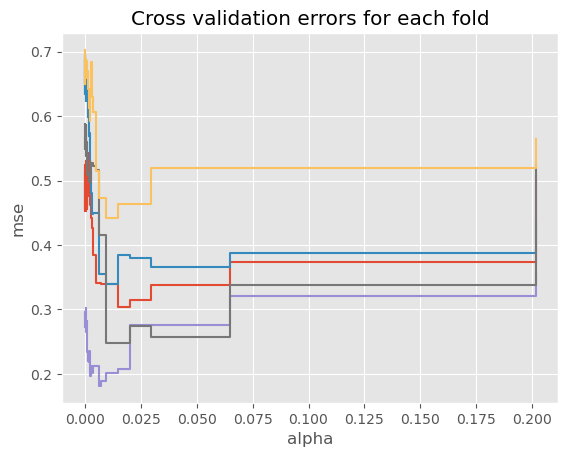

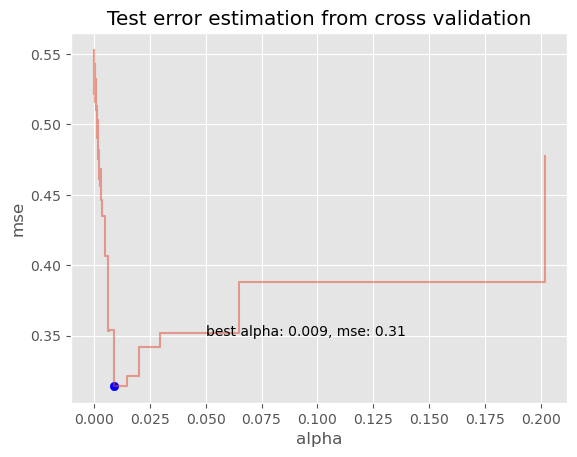

In [53]:

mse2 =  np.stack([x.mse for x in cv2], axis=0)
mse2_mean = mse2.mean(axis=0)
plt.plot(alphas_, mse2.T, drawstyle='steps-post')
# plt.grid()
plt.xlabel('alpha')
plt.ylabel('mse')
plt.title('Cross validation errors for each fold')

plt.show()


plt.plot(alphas_, mse2_mean, drawstyle='steps-post', alpha=0.5)
k = np.argmin(mse2_mean)
best_alpha2= alphas_[k]
best_mse2 = mse2_mean[k]
plt.annotate(f'best alpha: {best_alpha2:0.3f}, mse: {best_mse2:.2f}',
             (best_alpha2, best_mse2), (0.05, 0.35))
plt.scatter(x=best_alpha2, y=best_mse2, color='blue')
plt.xlabel('alpha')
plt.ylabel('mse')
# plt.grid()
plt.title('Test error estimation from cross validation')

plt.show()

In [54]:
alphas_[k-1:k+2]

array([0.00699391, 0.00924531, 0.01465305])

In [196]:
hitter.shape

(263, 20)

0.30223324888778175


/home/prokaj/.config/jupyterlab-desktop/jlab_server/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


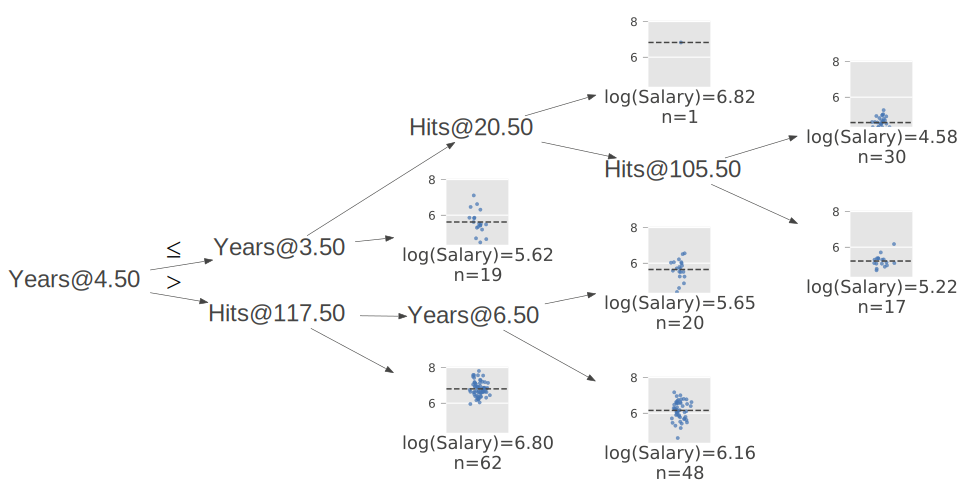

In [56]:
cv_tree = sktree.DecisionTreeRegressor(ccp_alpha=best_alpha).fit(*ds['train'])
print(make_scorer(mean_squared_error)(cv_tree, *ds['test']))
viz = dtreeviz(
    cv_tree, 
    *ds['train'], 
    feature_names=ds['train'][0].columns, 
    target_name='log(Salary)', 
    fancy=False,
    orientation='LR', 
    scale=2,
    label_fontsize=12
)

# viz2pdf(viz, 'plots/12-03-hitters-best-tree.pdf')
viz

# California housing data

In [57]:
housing = datasets.fetch_california_housing()

In [58]:
print(housing['DESCR'])

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

In [59]:
housing_X = pd.DataFrame(housing['data'], columns=housing['feature_names'])
housing_y = housing['target']
housing_X

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25
...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32


### Train test split

In [100]:
ds = data_splits(housing_X, housing_y, test_size=0.2, shuffle=True, random_state=1)

## Random forest

### helper function to evaluate a random forest regressor

It takes one random forest and computes the score of the regressor obtained by taking the first $i$ estimators in the model.
It can be used to see how the score depends on the number of estimators.

In [101]:
def eval_rf(rf, X, y, score=mean_absolute_error):
    X = np.asarray(X)
    y_pred = 0
    results = []
    for i, e in enumerate(tqdm(rf.estimators_), 1):
        y_pred = y_pred + e.predict(X)
        results.append((i, score(y_true=y, y_pred=y_pred/(i))))
    return pd.DataFrame(results, columns=['n_trees', 'test_error'])


In [102]:
mae = make_scorer(mean_absolute_error)
RF=skensemble.RandomForestRegressor
GBM = skensemble.GradientBoostingRegressor


In [104]:
rf_list = [
   RF(
      n_estimators=1000,
      max_features=m, 
      verbose=1, 
      random_state=1, 
      n_jobs=4
      # max_leaf_nodes=50
   ).fit(*ds['train']) 
   for m in ['sqrt', 2, 6]
]

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    5.7s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:  4.1min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.8s


: 

: 

In [95]:
results = {}

for rf in rf_list:
    results[f'RF, m={rf.max_features}'] = eval_rf(rf, *ds['test'])

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [89]:
RF?

Init signature:
RF(
    n_estimators=100,
    *,
    criterion='squared_error',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features=1.0,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=True,
    oob_score=False,
    n_jobs=None,
    random_state=None,
    verbose=0,
    warm_start=False,
    ccp_alpha=0.0,
    max_samples=None,
)
Docstring:     
A random forest regressor.

A random forest is a meta estimator that fits a number of classifying
decision trees on various sub-samples of the dataset and uses averaging
to improve the predictive accuracy and control over-fitting.
The sub-sample size is controlled with the `max_samples` parameter if
`bootstrap=True` (default), otherwise the whole dataset is used to build
each tree.

Read more in the :ref:`User Guide <forest>`.

Parameters
----------
n_estimators : int, default=100
    The number of trees in the forest.

    .. versionchanged:: 0.22
       

In [98]:
results['RF, m=6']

,n_trees,test_error
0,1,0.501933
1,2,0.472024
2,3,0.435302
3,4,0.428457
4,5,0.444112
...,...,...
995,996,0.407014
996,997,0.407015
997,998,0.406899
998,999,0.406892


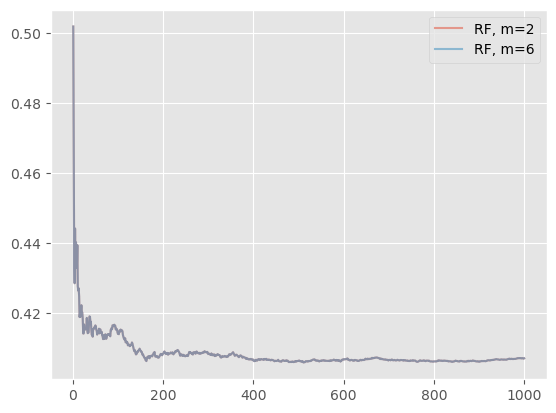

In [97]:
for k, res in results.items():
    plt.plot(res.n_trees, res.test_error, label=k, alpha=0.5)
plt.legend()
#plt.yscale('log')
plt.show()


## Gradient boosted trees

In [197]:
GBM.staged_predict?

Signature: GBM.staged_predict(self, X)
Docstring:
Predict regression target at each stage for X.

This method allows monitoring (i.e. determine error on testing set)
after each stage.

Parameters
----------
X : {array-like, sparse matrix} of shape (n_samples, n_features)
    The input samples. Internally, it will be converted to
    ``dtype=np.float32`` and if a sparse matrix is provided
    to a sparse ``csr_matrix``.

Yields
------
y : generator of ndarray of shape (n_samples,)
    The predicted value of the input samples.
File:      ~/.config/jupyterlab-desktop/jlab_server/lib/python3.8/site-packages/sklearn/ensemble/_gb.py
Type:      function


In [251]:
gbm = GBM(n_estimators=10, max_depth=4, random_state=1).fit(*ds['train'])

In [250]:
ds['test'][0].head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
4712,3.2500,39.0,4.503205,1.073718,1109.0,1.777244,34.06,-118.36
2151,1.9784,37.0,4.988584,1.038813,1143.0,2.609589,36.78,-119.78
15927,4.0132,46.0,4.480296,1.012315,1534.0,3.778325,37.73,-122.42
82,1.5208,52.0,3.908046,1.114943,200.0,2.298851,37.81,-122.28
8161,5.1795,37.0,5.406360,1.024735,711.0,2.512367,33.82,-118.13


In [255]:
def eval_gbm(gbm, X, y, score=mean_absolute_error):
    results = [(i, score(y_pred, y)) for i, y_pred in enumerate(gbm.staged_predict(X),1)]
    return pd.DataFrame(results, columns=['n_predictors', 'test_error'])


In [256]:
gbm_result = eval_gbm(gbm, *ds['test'])

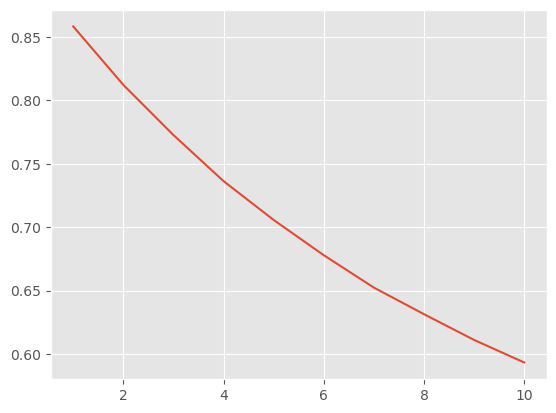

In [258]:
plt.plot('n_predictors', 'test_error', data=gbm_result)
plt.show()

In [445]:
GBM?

Init signature:
GBM(
    *,
    loss='squared_error',
    learning_rate=0.1,
    n_estimators=100,
    subsample=1.0,
    criterion='friedman_mse',
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_depth=3,
    min_impurity_decrease=0.0,
    init=None,
    random_state=None,
    max_features=None,
    alpha=0.9,
    verbose=0,
    max_leaf_nodes=None,
    warm_start=False,
    validation_fraction=0.1,
    n_iter_no_change=None,
    tol=0.0001,
    ccp_alpha=0.0,
)
Docstring:     
Gradient Boosting for regression.

GB builds an additive model in a forward stage-wise fashion;
it allows for the optimization of arbitrary differentiable loss functions.
In each stage a regression tree is fit on the negative gradient of the
given loss function.

Read more in the :ref:`User Guide <gradient_boosting>`.

Parameters
----------
loss : {'squared_error', 'ls', 'absolute_error', 'lad', 'huber',             'quantile'}, default='squared_error'
    Loss function

In [259]:
gbm_list = [
    GBM(
        n_estimators=1000, 
        loss='absolute_error',
        # max_leaf_nodes= d,
        max_depth=d, 
        verbose=1, 
        random_state=1
    ).fit(*ds['train']) 
    for d in [4,6]
]

      Iter       Train Loss   Remaining Time 
         1           0.8356           44.08s
         2           0.7901           43.20s
         3           0.7515           42.62s
         4           0.7175           42.20s
         5           0.6866           42.02s
         6           0.6596           42.08s
         7           0.6330           42.00s
         8           0.6096           41.89s
         9           0.5865           41.69s
        10           0.5654           41.54s
        20           0.4561           41.16s
        30           0.4112           40.79s
        40           0.3897           41.11s
        50           0.3757           40.65s
        60           0.3640           40.17s
        70           0.3525           39.68s
        80           0.3464           39.16s
        90           0.3416           38.65s
       100           0.3371           38.14s
       200           0.3066           33.75s
       300           0.2887           29.47s
       40

In [520]:
gbm_list.append(GBM(n_estimators=1000, loss='absolute_error',
                # max_leaf_nodes= d,
                max_depth=6, 
                verbose=1,
                subsample=0.5,
                random_state=1).fit(*ds['train']))

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.8316           0.0560            3.48m
         2           0.7754           0.0482            2.30m
         3           0.7361           0.0456            1.93m
         4           0.6952           0.0408            1.82m
         5           0.6478           0.0349            1.68m
         6           0.6257           0.0328            1.57m
         7           0.5937           0.0273            1.51m
         8           0.5701           0.0239            1.44m
         9           0.5357           0.0236            1.39m
        10           0.5134           0.0208            1.37m
        20           0.3961           0.0059            1.41m
        30           0.3537           0.0018            1.29m
        40           0.3362           0.0019            1.19m
        50           0.3177           0.0002            1.13m
        60           0.3188           0.0007            1.08m
       

In [219]:
for gbm in gbm_list:
    results[f'GBM, max depth={gbm.max_depth}, subsample={gbm.subsample:.2f}']= eval_gbm(gbm, *ds['test'])


In [434]:
import lightgbm

In [448]:
#lightgbm.LGBMRegressor?

Init signature:
lightgbm.LGBMRegressor(
    boosting_type: str = 'gbdt',
    num_leaves: int = 31,
    max_depth: int = -1,
    learning_rate: float = 0.1,
    n_estimators: int = 100,
    subsample_for_bin: int = 200000,
    objective: Union[str, Callable, NoneType] = None,
    class_weight: Union[Dict, str, NoneType] = None,
    min_split_gain: float = 0.0,
    min_child_weight: float = 0.001,
    min_child_samples: int = 20,
    subsample: float = 1.0,
    subsample_freq: int = 0,
    colsample_bytree: float = 1.0,
    reg_alpha: float = 0.0,
    reg_lambda: float = 0.0,
    random_state: Union[int, numpy.random.mtrand.RandomState, NoneType] = None,
    n_jobs: int = -1,
    silent: Union[bool, str] = 'warn',
    importance_type: str = 'split',
    **kwargs,
)
Docstring:      LightGBM regressor.
Init docstring:
Construct a gradient boosting model.

Parameters
----------
boosting_type : str, optional (default='gbdt')
    'gbdt', traditional Gradient Boosting Decision Tree.
    'dart'

In [435]:
def eval_lgbm(lgbm, X, y, score_fn=mean_absolute_error):
    results = []
    y_pred = 0
    for k in tqdm(range(lgbm.n_estimators)):
        y_pred = y_pred + lgbm.predict(X, start_iteration=k, num_iteration=1)
        results.append((k+1, score_fn(y_true=y, y_pred=y_pred)))
    return results

In [585]:

lgbm_params=dict(n_estimators=2000, random_state=1, learning_rate=0.1, importance_type='gain')
lgbm_list = [lightgbm.LGBMRegressor(**lgbm_params, num_leaves=d,
                                   ).fit(*ds['train']) for d in [12,24,32]]
lgbm_list.append(lightgbm.LGBMRegressor(**lgbm_params, #num_leaves=d,
                                        num_leaves=12,
                                        subsample=0.5,
                                        subsample_freq=1,
                                       ).fit(*ds['train']))



In [586]:
results_lgbm = {} 
for (k,(X,y)), gbm in itertools.product(ds.items(), lgbm_list):
    if 'test' in k:
        results_lgbm[f'num leaves={gbm.num_leaves}, subsample={gbm.subsample:.2f}']= eval_lgbm(gbm, X, y)


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [492]:
res = {k.replace(' test',''):v for k,v in  results.items() if 'test' in k}
res = {k:v for k,v in  res.items() if 'subsample' in k}
res.keys()

dict_keys(['sklearn GBM, max depth=4, subsample=1.00', 'sklearn GBM, max depth=6, subsample=1.00', 'sklearn GBM, max depth=6, subsample=0.50', 'lightGBM, max depth=4, subsample=1.00', 'lightGBM, max depth=6, subsample=1.00', 'lightGBM, max depth=6, subsample=0.50'])

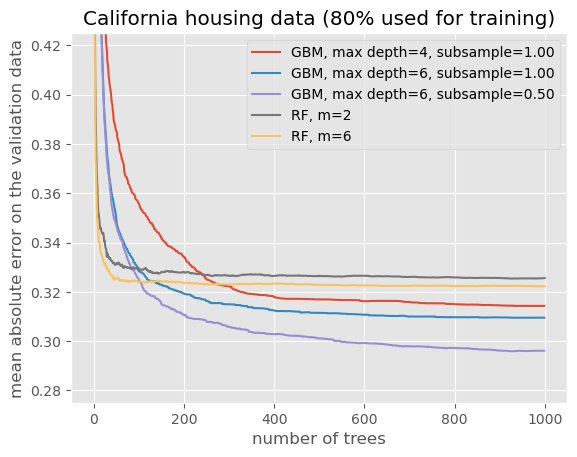

In [584]:
for k,v in results.items():
    if True or 'test' in k:
        plt.plot(*zip(*results[k]), label=k.replace(', test',''))    
# plt.yscale('log')
plt.ylim(0.275,0.425)
plt.legend()
# plt.grid()
fraction = len(ds['train'][1])/(len(ds['train'][1])+len(ds['test'][1]))
plt.title(f'California housing data ({fraction*100:.0f}% used for training)')
plt.xlabel('number of trees')
plt.ylabel('mean absolute error on the validation data')



In [441]:
print(f'{housing_y.mean():.3f}, {np.median(housing_y):.3f}, {housing_y.std():.3f}')

2.069, 1.797, 1.154


In [442]:
np.abs(housing_y-np.median(housing_y)).mean()

0.8835413124999999

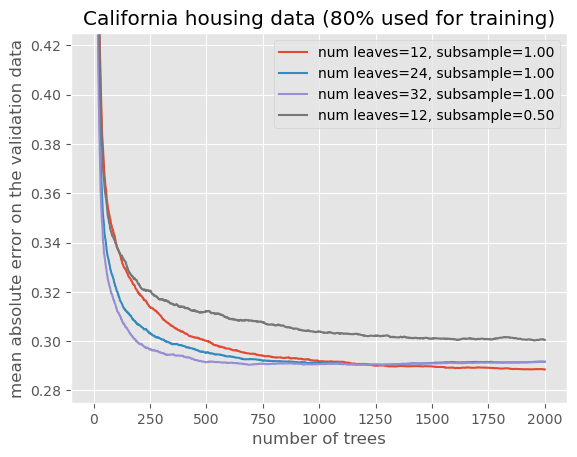

In [587]:
for k,v in results_lgbm.items():
    if True or 'test' in k:
        plt.plot(*zip(*results_lgbm[k]), label=k.replace(', test',''))    

plt.ylim(0.275,0.425)
plt.legend()
# plt.grid()
fraction = len(ds['train'][1])/(len(ds['train'][1])+len(ds['test'][1]))
plt.title(f'California housing data LGBM({fraction*100:.0f}% used for training)')
plt.xlabel('number of trees')
plt.ylabel('mean absolute error on the validation data')



In [495]:
gbm_list[2].get_params(),lgbm_list[2].get_params()

({'alpha': 0.9,
  'ccp_alpha': 0.0,
  'criterion': 'friedman_mse',
  'init': None,
  'learning_rate': 0.1,
  'loss': 'absolute_error',
  'max_depth': 6,
  'max_features': None,
  'max_leaf_nodes': None,
  'min_impurity_decrease': 0.0,
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'min_weight_fraction_leaf': 0.0,
  'n_estimators': 1000,
  'n_iter_no_change': None,
  'random_state': 1,
  'subsample': 0.5,
  'tol': 0.0001,
  'validation_fraction': 0.1,
  'verbose': 1,
  'warm_start': False},
 {'boosting_type': 'gbdt',
  'class_weight': None,
  'colsample_bytree': 1.0,
  'importance_type': 'split',
  'learning_rate': 0.1,
  'max_depth': 6,
  'min_child_samples': 20,
  'min_child_weight': 0.001,
  'min_split_gain': 0.0,
  'n_estimators': 1000,
  'n_jobs': -1,
  'num_leaves': 31,
  'objective': None,
  'random_state': 1,
  'reg_alpha': 0.0,
  'reg_lambda': 0.0,
  'silent': 'warn',
  'subsample': 0.5,
  'subsample_for_bin': 200000,
  'subsample_freq': 1})

In [568]:
lgbm = lgbm_list[1]
lgbm.feature_importances_

array([57644.10326952,  4429.0972948 ,  3016.09954782,  1510.88716825,
        1278.57591327, 13873.82587695, 12368.50089968, 14210.04102758])

In [565]:
lgbm?

Type:           LGBMRegressor
String form:    LGBMRegressor(max_depth=6, n_estimators=1000, random_state=1)
File:           ~/.local/lib/python3.8/site-packages/lightgbm/sklearn.py
Docstring:      LightGBM regressor.
Init docstring:
Construct a gradient boosting model.

Parameters
----------
boosting_type : str, optional (default='gbdt')
    'gbdt', traditional Gradient Boosting Decision Tree.
    'dart', Dropouts meet Multiple Additive Regression Trees.
    'goss', Gradient-based One-Side Sampling.
    'rf', Random Forest.
num_leaves : int, optional (default=31)
    Maximum tree leaves for base learners.
max_depth : int, optional (default=-1)
    Maximum tree depth for base learners, <=0 means no limit.
learning_rate : float, optional (default=0.1)
    Boosting learning rate.
    You can use ``callbacks`` parameter of ``fit`` method to shrink/adapt learning rate
    in training using ``reset_parameter`` callback.
    Note, that this will ignore the ``learning_rate`` argument in traini

# Spam

In [55]:
spam = datasets.fetch_openml('Spambase')
spam.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [56]:
print(spam['DESCR'])

**Author**: Mark Hopkins, Erik Reeber, George Forman, Jaap Suermondt    
**Source**: [UCI](https://archive.ics.uci.edu/ml/datasets/spambase)   
**Please cite**: [UCI](https://archive.ics.uci.edu/ml/citation_policy.html)

SPAM E-mail Database  
The "spam" concept is diverse: advertisements for products/websites, make money fast schemes, chain letters, pornography... Our collection of spam e-mails came from our postmaster and individuals who had filed spam.  Our collection of non-spam e-mails came from filed work and personal e-mails, and hence the word 'george' and the area code '650' are indicators of non-spam.  These are useful when constructing a personalized spam filter.  One would either have to blind such non-spam indicators or get a very wide collection of non-spam to generate a general purpose spam filter.
 
For background on spam:  
Cranor, Lorrie F., LaMacchia, Brian A.  Spam! Communications of the ACM, 41(8):74-83, 1998.  

### Attribute Information:  
The last column denotes

In [57]:
spam['data'].head()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,word_freq_conference,char_freq_%3B,char_freq_%28,char_freq_%5B,char_freq_%21,char_freq_%24,char_freq_%23,capital_run_length_average,capital_run_length_longest,capital_run_length_total
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.0,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61.0,278.0
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.0,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101.0,1028.0
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.0,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485.0,2259.0
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.0,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40.0,191.0
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.0,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40.0,191.0


In [99]:
spam_y = np.array(list(map(int, spam['target'].values)))

In [100]:
spam_ds = data_splits(spam['data'], spam_y, test_size=0.2, shuffle=True, random_state=1)

In [72]:
import lightgbm 
import xgboost
from sklearn.metrics import classification_report

In [77]:
spam_lgbm = lightgbm.LGBMClassifier(n_estimators=500, 
                                    importance_type='gain', 
                                    num_leaves=12, 
                                    random_state=1).fit(*spam_ds['train'])

<AxesSubplot:xlabel='importance', ylabel='name'>

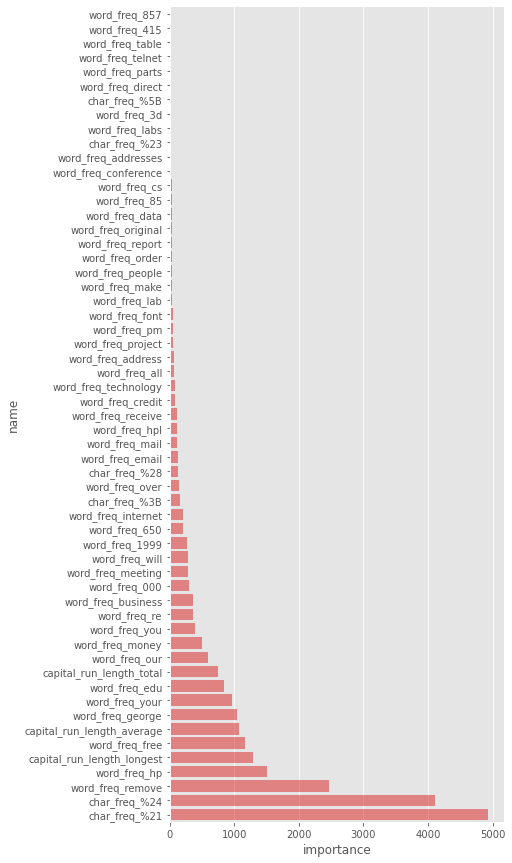

In [82]:
importance = pd.DataFrame({'importance': spam_lgbm.feature_importances_, 'name': spam['data'].columns})
plt.figure(figsize=(6,15))
sns.barplot(x='importance', y='name', data=importance.sort_values('importance'), color='red', alpha=0.5)

In [74]:
acc=make_scorer(accuracy_score)
mk_rep = make_scorer(classification_report)
acc(spam_lgbm, *spam_ds['test'])
print(mk_rep(spam_lgbm, *spam_ds['test']))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       564
           1       0.94      0.94      0.94       357

    accuracy                           0.95       921
   macro avg       0.95      0.95      0.95       921
weighted avg       0.95      0.95      0.95       921



In [64]:
from sklearn.linear_model import LogisticRegressionCV

In [68]:
spam_log = LogisticRegressionCV(penalty='l2', 
                                solver='liblinear',
                                max_iter=1000, 
                                refit=True,
                                cv=5,
                                Cs=[0.01,0.1,1,10,100]).fit(*spam_ds['train'])

In [75]:
print(mk_rep(spam_log, *spam_ds['test']))

              precision    recall  f1-score   support

           0       0.93      0.96      0.95       564
           1       0.94      0.89      0.91       357

    accuracy                           0.93       921
   macro avg       0.93      0.93      0.93       921
weighted avg       0.93      0.93      0.93       921



In [84]:
spam_lgbm2 = lightgbm.LGBMClassifier(n_estimators=1000, 
                                    importance_type='gain', 
                                    num_leaves=6, 
                                    learning_rate=0.05,
                                    random_state=1).fit(*spam_ds['train'])

In [85]:
print(mk_rep(spam_lgbm2, *spam_ds['test']))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97       564
           1       0.94      0.95      0.95       357

    accuracy                           0.96       921
   macro avg       0.96      0.96      0.96       921
weighted avg       0.96      0.96      0.96       921



In [90]:
xgboost.XGBClassifier?

Init signature:
xgboost.XGBClassifier(
    *,
    objective: Union[str, Callable[[numpy.ndarray, numpy.ndarray], Tuple[numpy.ndarray, numpy.ndarray]], NoneType] = 'binary:logistic',
    use_label_encoder: bool = True,
    **kwargs: Any,
) -> None
Docstring:     
Implementation of the scikit-learn API for XGBoost classification.


Parameters
----------

    n_estimators : int
        Number of boosting rounds.
    use_label_encoder : bool
        (Deprecated) Use the label encoder from scikit-learn to encode the labels. For new
        code, we recommend that you set this parameter to False.

    max_depth :  Optional[int]
        Maximum tree depth for base learners.
    learning_rate : Optional[float]
        Boosting learning rate (xgb's "eta")
    verbosity : Optional[int]
        The degree of verbosity. Valid values are 0 (silent) - 3 (debug).
    objective : typing.Union[str, typing.Callable[[numpy.ndarray, numpy.ndarray], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]
  

In [105]:
spam_xg = xgboost.XGBClassifier(use_label_encoder=False, 
                                reg_lambda=0.1, 
                                n_estimators=100).fit(*spam_ds['train'])

[15:41:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [106]:
print(mk_rep(spam_xg,*spam_ds['test']))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       564
           1       0.94      0.94      0.94       357

    accuracy                           0.95       921
   macro avg       0.95      0.95      0.95       921
weighted avg       0.95      0.95      0.95       921



# Heart data

In [161]:
heart=ISLR2data('Heart')

In [168]:
heart.isna().sum()

Age          0
Sex          0
ChestPain    0
RestBP       0
Chol         0
Fbs          0
RestECG      0
MaxHR        0
ExAng        0
Oldpeak      0
Slope        0
Ca           0
Thal         0
AHD          0
dtype: int64

In [169]:
heart = heart.dropna().copy()
heart

,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,AHD
1,63,1,0,145,233,1,2,150,0,2.3,3,0.0,0,0
2,67,1,1,160,286,0,2,108,1,1.5,2,3.0,1,1
3,67,1,1,120,229,0,2,129,1,2.6,2,2.0,2,1
4,37,1,2,130,250,0,0,187,0,3.5,3,0.0,1,0
5,41,0,3,130,204,0,2,172,0,1.4,1,0.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,1,140,241,0,0,123,1,0.2,2,0.0,2,1
299,45,1,0,110,264,0,0,132,0,1.2,2,0.0,2,1
300,68,1,1,144,193,1,0,141,0,3.4,2,2.0,2,1
301,57,1,1,130,131,0,0,115,1,1.2,2,1.0,2,1


In [133]:
for k in 'AHD ChestPain Thal'.split():
    heart[k], _ = pd.factorize(heart[k])

Init signature:
skensemble.RandomForestClassifier(
    n_estimators=100,
    *,
    criterion='gini',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features='auto',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=True,
    oob_score=False,
    n_jobs=None,
    random_state=None,
    verbose=0,
    warm_start=False,
    class_weight=None,
    ccp_alpha=0.0,
    max_samples=None,
)
Docstring:     
A random forest classifier.

A random forest is a meta estimator that fits a number of decision tree
classifiers on various sub-samples of the dataset and uses averaging to
improve the predictive accuracy and control over-fitting.
The sub-sample size is controlled with the `max_samples` parameter if
`bootstrap=True` (default), otherwise the whole dataset is used to build
each tree.

Read more in the :ref:`User Guide <forest>`.

Parameters
----------
n_estimators : int, default=100
    The number of trees in t

In [409]:
heart_ds = data_splits(heart.drop(columns='AHD').values, heart.AHD.values, 
                       shuffle=True, test_size=0.2, random_state=42)

In [529]:
max_leaf_nodes = 3
ccp_alpha = 0
max_features = 4
n_trees = 200

bagging_heart = skensemble.BaggingClassifier(base_estimator=sktree.DecisionTreeClassifier(max_leaf_nodes=max_leaf_nodes,
                                                                                          ccp_alpha=ccp_alpha), 
                                             n_estimators=n_trees,  
                                             #oob_score=True, 
                                             random_state=1).fit(*heart_ds['train'])

rf_heart = skensemble.RandomForestClassifier(max_leaf_nodes=max_leaf_nodes, 
                                             ccp_alpha=ccp_alpha,
                                             n_estimators=n_trees, 
                                             max_features= max_features,
                                             #oob_score=True, 
                                             random_state=1).fit(*heart_ds['train'])

In [506]:
len(bagging_heart.estimators_), len(rf_heart.estimators_)

(200, 200)

In [530]:
def oob_and_test_score(bagging, est_, ds):
    bagging.estimators_ = est_
    bagging._set_oob_score(*ds['train'])
    return {
        'n_trees': len(est_), 
        'oob': bagging.oob_score_,
        'test' : make_scorer(accuracy_score)(bagging,*ds['test'])
        }
            
est = bagging_heart.estimators_

bagging_heart_test_oob = pd.DataFrame([oob_and_test_score(bagging_heart, est[:i], heart_ds) 
                                       for i in tqdm(range(1, len(est)+1))]).set_index('n_trees')

bagging_heart.estimators_ = est


  0%|          | 0/200 [00:00<?, ?it/s]

/home/prokaj/.local/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py:706: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn(
/home/prokaj/.local/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py:712: RuntimeWarning: invalid value encountered in true_divide
  oob_decision_function = predictions / predictions.sum(axis=1)[:, np.newaxis]
/home/prokaj/.local/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py:706: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn(
/home/prokaj/.local/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py:712: RuntimeWarning: invalid value encountered in true_divide
  oob_decision_function = predictions / predictions.sum(axis=1)[:, np.newaxis]
/home/prokaj/.local/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py:706: UserWarning: Some inputs do 

In [531]:

def rf_oob_and_test_score(rf, est_, ds):
    rf.estimators_ = est_
    if not isinstance(rf.n_classes_,list):
        rf.n_classes_ = [rf.n_classes_]
    rf._set_oob_score_and_attributes(*ds['train'])
    X,y=ds['test']
    #test_r = accuracy_score(y_pred = 1*(np.stack([e.predict(X) for e in est_], axis=0).mean(axis=0)>0.5),
    #               y_true = y)
    return {
        'n_trees': len(est_), 
        'oob': rf.oob_score_,
        'test' : make_scorer(accuracy_score)(rf,*ds['test']),
        #'test_R' : test_r 
        }

est = rf_heart.estimators_
rf_heart_test_oob = pd.DataFrame([rf_oob_and_test_score(rf_heart, est[:i], heart_ds) for i in tqdm(range(1, len(est)+1))]).set_index('n_trees')
rf_heart.estimators_ = est

  0%|          | 0/200 [00:00<?, ?it/s]

/home/prokaj/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:549: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/prokaj/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:549: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/prokaj/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:549: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/prokaj/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:549: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/prokaj/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:549: UserWarning: Some inputs do not hav

In [533]:
single_tree_acc = make_scorer(accuracy_score)(sktree.DecisionTreeClassifier(max_leaf_nodes=max_leaf_nodes,
                                                                            ccp_alpha=ccp_alpha, 
                                                                            random_state=1).fit(*heart_ds['train']), 
                                              *heart_ds['test'])

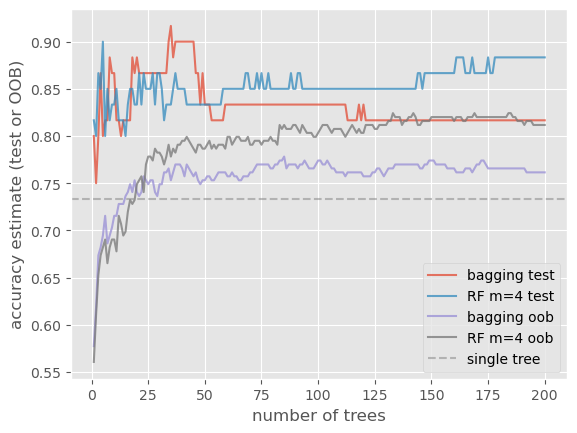

In [534]:

plt.plot(bagging_heart_test_oob.index, bagging_heart_test_oob.test, alpha=0.75, label='bagging test')
plt.plot(rf_heart_test_oob.index, rf_heart_test_oob.test, alpha=0.75, label=f'RF m={rf_heart.max_features} test')
plt.plot(bagging_heart_test_oob.index, bagging_heart_test_oob.oob, alpha=0.75, label='bagging oob')
plt.plot(rf_heart_test_oob.index, rf_heart_test_oob.oob, alpha=0.75, label=f'RF m={rf_heart.max_features} oob')

plt.axhline(single_tree_acc, linestyle='--', color='gray', alpha=0.5, label='single tree')
plt.legend()
plt.xlabel('number of trees')
plt.ylabel('accuracy estimate (test or OOB)')



In [589]:
max_leaf_nodes = 3
ccp_alpha = 0
max_features = 4
n_trees = 200
gbm = skensemble.GradientBoostingClassifier(n_estimators=200,
                                            learning_rate=0.1,
                                            max_leaf_nodes=3).fit(*heart_ds['train'])


In [590]:
gbm.feature_importances_,gbm.feature_importances_.sum()

(array([0.07162468, 0.03987906, 0.13971983, 0.05110918, 0.04518308,
        0.00105478, 0.00643771, 0.07974866, 0.07961942, 0.06101093,
        0.0646928 , 0.21026721, 0.14965265]),
 1.0000000000000002)

In [549]:
importance = pd.DataFrame({'importance':gbm.feature_importances_, 'name': heart.drop(columns='AHD').columns})

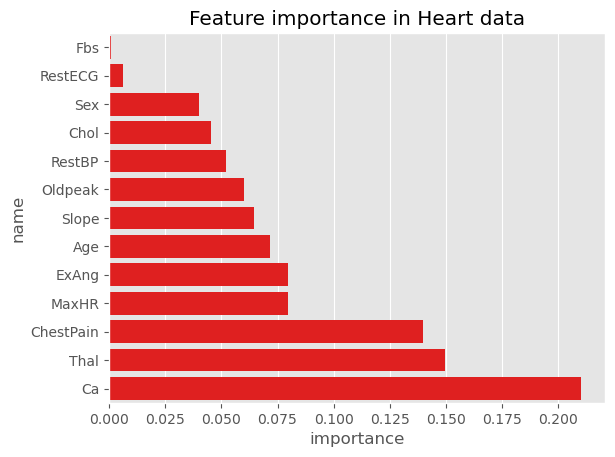

In [559]:
importance=importance.sort_values(by='importance')
sns.barplot(y='name', x='importance', data=importance, color='red')
plt.title('Feature importance in Heart data')


Type:        GradientBoostingClassifier
String form: GradientBoostingClassifier(max_leaf_nodes=3, n_estimators=200)
Length:      200
File:        ~/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb.py
Docstring:  
Gradient Boosting for classification.

GB builds an additive model in a
forward stage-wise fashion; it allows for the optimization of
arbitrary differentiable loss functions. In each stage ``n_classes_``
regression trees are fit on the negative gradient of the
binomial or multinomial deviance loss function. Binary classification
is a special case where only a single regression tree is induced.

Read more in the :ref:`User Guide <gradient_boosting>`.

Parameters
----------
loss : {'deviance', 'exponential'}, default='deviance'
    The loss function to be optimized. 'deviance' refers to
    deviance (= logistic regression) for classification
    with probabilistic outputs. For loss 'exponential' gradient
    boosting recovers the AdaBoost algorithm.

learning_rate : float

In [ ]:
sort_values

## Checkerboard example

In [ ]:
np.random.seed(9)
X = np.random.uniform(-1,1, size=(2,200))
y = np.sign(X[0])* np.sign(X[1])
ex_tree = sktree.DecisionTreeRegressor().fit(X.T, y)

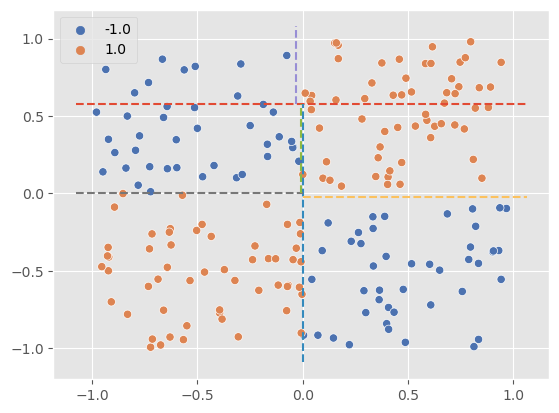

In [ ]:
sns.scatterplot(x=X[0],y=X[1],hue=y, palette=sns.palettes.SEABORN_PALETTES['deep'][:2]) 
#, hue_norm=(0.5,0.5))

for i,line in enumerate(cut_lines(ex_tree, X.T)):
    plt.plot(*line,'--',)



In [ ]:
print(sktree.export_text(ex_tree,feature_names=['X1','X2'], decimals=2))

|--- X2 <= 0.58
|   |--- X1 <= 0.00
|   |   |--- X2 <= 0.00
|   |   |   |--- value: [1.00]
|   |   |--- X2 >  0.00
|   |   |   |--- X1 <= -0.01
|   |   |   |   |--- value: [-1.00]
|   |   |   |--- X1 >  -0.01
|   |   |   |   |--- value: [1.00]
|   |--- X1 >  0.00
|   |   |--- X2 <= -0.02
|   |   |   |--- value: [-1.00]
|   |   |--- X2 >  -0.02
|   |   |   |--- value: [1.00]
|--- X2 >  0.58
|   |--- X1 <= -0.03
|   |   |--- value: [-1.00]
|   |--- X1 >  -0.03
|   |   |--- value: [1.00]

